In [20]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
from tqdm import tqdm_notebook

FIGSIZE=(20,10)
SEED=17

In [2]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer


from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pool of regressors
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor

In [3]:
target = 'Energy_consumption'

In [4]:
train_initial = pd.read_csv('../data/train.csv')
test_initial = pd.read_csv('../data/test.csv')

X_test = test_initial.drop('Id', axis=1)

X = train_initial.drop(['Id', target], axis=1)
y = train_initial[target].values.reshape(-1,1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25,
                                                   random_state=SEED,
                                                   shuffle=True)

In [11]:
catcols = X_train.select_dtypes(include='object').columns
onehot = OneHotEncoder()

train_trans = pd.DataFrame(onehot.fit_transform(X_train[catcols]).toarray())
test_trans = pd.DataFrame(onehot.transform(X_valid[catcols]).toarray())

X_train = pd.concat([X_train.drop(catcols, axis=1).reset_index(drop=True), 
                     train_trans], axis=1)

X_valid = pd.concat([X_valid.drop(catcols, axis=1).reset_index(drop=True), 
                    test_trans], axis=1)


catcols = X.select_dtypes(include='object').columns
onehot = OneHotEncoder() 

train_trans = pd.DataFrame(onehot.fit_transform(X[catcols]).toarray())
X_train_full = pd.concat([X.drop(catcols, axis=1).reset_index(drop=True),
                    train_trans], axis=1)

test_trans = pd.DataFrame(onehot.transform(X_test[catcols]).toarray())
X_test = pd.concat([X_test.drop(catcols, axis=1).reset_index(drop=True), 
                    test_trans], axis=1)

In [53]:
from sklearn.base import clone

def prediction_cluster_folds(train_X, train_y, test_X,model,
                            n_clusters=4,n_splits=5):
    """
        train_X -- ndarray
        train_y -- ndarray with (n, 1) shape
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
    predicted_target = kmeans.fit(train_y).predict(train_y)
    
    predictions_holdout = np.zeros((test_X.shape[0], 1))
    predictions_val = np.zeros((train_X.shape[0], 1))

    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    for (tr_ind, val_ind) in skf.split(train_X, predicted_target):
        X_train_fold = train_X[tr_ind]
        y_train_fold = np.squeeze(train_y[tr_ind])

        X_valid_fold = train_X[val_ind]
        y_valid_fold = np.squeeze(train_y[val_ind])

        model_fold = clone(model)
        y_pred = model_fold.fit(X_train_fold, y_train_fold).predict(X_valid_fold).reshape(-1,1)
        scores.append(mean_squared_error(y_valid_fold, y_pred))
        predictions_val[val_ind] = y_pred

        y_pred_holdout = model_fold.predict(test_X).reshape(-1,1)
        predictions_holdout += y_pred_holdout
        
    
    predictions_holdout /= skf.n_splits
    return predictions_holdout, scores, predictions_val

In [39]:
def prediction_cluster_folds_ensemble(train_X, train_y, test_X, models, 
                                      n_clusters=4,n_splits=5,
                                     seed=SEED):
    """
        train_X -- ndarray
        train_y -- ndarray with (n, 1) shape
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
    predicted_target = kmeans.fit(train_y).predict(train_y)
    
    predictions_holdout = np.zeros((test_X.shape[0], 1))
    predictions_val = np.zeros((train_X.shape[0], 1))

    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for (tr_ind, val_ind) in tqdm_notebook(skf.split(train_X, predicted_target), 
                                           total=skf.n_splits):
        X_train_fold = train_X[tr_ind]
        y_train_fold = np.squeeze(train_y[tr_ind])

        X_valid_fold = train_X[val_ind]
        y_valid_fold = np.squeeze(train_y[val_ind])
        
        # ensembling weighting average
        pred_test_inline = np.zeros((test_X.shape[0], 1))
        pred_val_inline = np.zeros((X_valid_fold.shape[0], 1))
        weight_sum = 0
        for (type_model, alpha, model) in models:
            if type_model == 1:
                model_fold = clone(model)
                y_pred = model_fold.fit(X_train_fold, y_train_fold).predict(X_valid_fold).reshape(-1,1)
                pred_val_inline += alpha * y_pred

                y_pred = model_fold.predict(test_X).reshape(-1,1)
                pred_test_inline += alpha * y_pred
                weight_sum += alpha
            else:
                y_pred = model.fit(X_train_fold, y_train_fold, 
                                   X_valid_fold, y_valid_fold).predict(X_valid_fold)
                pred_val_inline += alpha * y_pred
                
                y_pred = model.predict(test_X)
                pred_test_inline += alpha * y_pred
                weight_sum += alpha
        
        pred_test_inline /= weight_sum
        pred_val_inline /= weight_sum
        ####
        predictions_val[val_ind] = pred_val_inline
        
        scores.append(mean_squared_error(y_valid_fold, pred_val_inline))
        predictions_holdout += pred_test_inline
        
    
    predictions_holdout /= skf.n_splits
    return predictions_holdout, scores, predictions_val

In [13]:
alpha=0.5

zoo_models = [ (alpha, XGBRegressor(n_estimators=100, 
                             random_state=SEED, 
                             n_jobs=-1)),
              (alpha, LGBMRegressor(n_estimators=100,
                           n_jobs=-1,
                           random_state=SEED))
]

In [22]:
predictions_test = np.zeros((X_test.shape[0], 1))
predictions_val = np.zeros((X_train_full.shape[0], 1))

t = 10

for i in tqdm_notebook(range(t), total=t):
    y_pred, scores, y_pred_val = prediction_cluster_folds_ensemble(X_train_full.values, y, 
                                                                   X_test.values,  
                                                                   zoo_models,
                                                                   n_clusters=4, 
                                                                   n_splits=7,
                                                                   seed=SEED+i)
    predictions_test += y_pred
    predictions_val += y_pred_val
    
predictions_test /= t
predictions_val /= t

A Jupyter Widget

In [23]:
mean_squared_error(y, predictions_val)

648459.1982865153

In [24]:
submission = pd.DataFrame(test_initial['Id'], columns=['Id'])
submission[target] = predictions_test
submission.to_csv('../data/submissions/xgb_lgb_oob_10seeds_ensemble.csv', index=False)

### Trying NN

In [30]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

def create_model(input_shape):
    inps = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inps)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1)(x)
    model = Model(inputs=inps, outputs=x)
    model.compile(
        optimizer=Adam(lr=1e-3),
        loss=['mse']
    )
    #model.summary()
    return model

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [32]:
from keras import callbacks
from sklearn.metrics import mean_squared_error

test_predictions = []
metric_results = []
scaler = StandardScaler()
X_array = scaler.fit_transform(X_train_full.values)
X_test_array = scaler.transform(X_test.values)

for ind, (tr, val) in tqdm_notebook(enumerate(kf.split(X_array)), total=kf.n_splits):
    X_tr = X_array[tr]
    y_tr = y[tr]

    X_vl = X_array[val]
    y_vl = y[val]
    
    model = create_model((X_tr.shape[1],))
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=0, 
                                 mode='auto', restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, 
                                      mode='auto', verbose=0)
    model.fit(
        X_tr, y_tr, epochs=500, batch_size=256, validation_data=(X_vl, y_vl), verbose=False, callbacks=[es, rlr]
    )
    test_predictions.append(model.predict(X_test.values).flatten())
    metric_results.append(mean_squared_error(y_vl, model.predict(X_vl).flatten()))
    print(metric_results[-1])
    
print(f'Average MSE: {np.mean(metric_results)}')

A Jupyter Widget


Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00119: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch

Epoch 00129: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 00129: early stopping
598808.7256662837

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00107: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch

Epoch 00117: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 00117: early stopping
844159.3

In [121]:
class NN():
    
    def __init__(self, input_shape, epochs, batch_size, dropout=.2):
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size=batch_size
        self.dropout = dropout
        
        
    def _init_model(self):
        inps = Input(shape=self.input_shape)
        x = Dense(256, activation='relu')(inps)
        x = Dropout(self.dropout)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(.5 * self.dropout)(x)
        x = Dense(1)(x)
        model = Model(inputs=inps, outputs=x)
        model.compile(
            optimizer=Adam(lr=1e-3),
            loss=['mse']
        )
        return model
    
    def fit(self, train_X, train_y, val_X, val_y):
        self.model = self._init_model()

        es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=0, 
                                     mode='auto', restore_best_weights=True)
        rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, 
                                          mode='auto', verbose=0)
        self.model.fit(
            train_X, train_y, epochs=self.epochs, batch_size=self.batch_size, 
            validation_data=(val_X, val_y), verbose=False, 
            callbacks=[es, rlr]
        )
        return self
    
    def predict(self, test_X):
        pred = self.model.predict(test_X).flatten().reshape(-1,1)
        return pred

In [46]:
alpha=0.5

zoo_models = [ (1,alpha, XGBRegressor(n_estimators=100, 
                             random_state=SEED, 
                             n_jobs=-1)),
              (1,alpha, LGBMRegressor(n_estimators=100,
                           n_jobs=-1,
                           random_state=SEED)),
              (0, alpha, NN(input_shape=(X_array.shape[1],), epochs=500, batch_size=256))
]

In [47]:
y_pred, scores, y_pred_val = prediction_cluster_folds_ensemble(X_array, y, 
                                                               X_test_array,  
                                                               zoo_models,
                                                               n_clusters=4, 
                                                               n_splits=7,
                                                               seed=SEED)

A Jupyter Widget

In [48]:
np.mean(scores)

643817.026045401

In [49]:
predictions_test = np.zeros((X_test_array.shape[0], 1))
predictions_val = np.zeros((X_array.shape[0], 1))

t = 10

for i in tqdm_notebook(range(t), total=t):
    y_pred, _, y_pred_val = prediction_cluster_folds_ensemble(X_array, y, 
                                                           X_test_array,  
                                                           zoo_models,
                                                           n_clusters=4, 
                                                           n_splits=7,
                                                           seed=SEED+i)
    predictions_test += y_pred
    predictions_val += y_pred_val
    
predictions_test /= t
predictions_val /= t

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [50]:
mean_squared_error(y, predictions_val)

626093.5104983785

In [51]:
submission = pd.DataFrame(test_initial['Id'], columns=['Id'])
submission[target] = predictions_test
submission.to_csv('../data/submissions/xgb_lgb_oob_nn_10seeds_ensemble.csv', index=False)

### Trying random subspaces

In [52]:
subspace = [.3, .5, .6, .7, .8, .9, .95]

In [55]:
T = 3
subspace_res = {}
for ss in tqdm_notebook(subspace, total=len(subspace)):
    
    pred_xgb = np.zeros((X_array.shape[0], 1))
    pred_lgb = np.zeros((X_array.shape[0], 1))
    pred_rf = np.zeros((X_array.shape[0], 1))
    
    for t in range(T):
        rf = RandomForestRegressor(n_estimators=100, max_depth=3, max_features=ss, 
                                   random_state=SEED+t, n_jobs=-1)
        _, _, y_pred_rf = prediction_cluster_folds(X_array, y, X_test_array, rf, 
                                                  n_clusters=4, 
                                                  n_splits=5)
        pred_rf += y_pred_rf
        
        rf = LGBMRegressor(n_estimators=100, colsample_bytree=ss, 
                           random_state=SEED+t, n_job=-1)
        _, _, y_pred_lgb = prediction_cluster_folds(X_array, y, X_test_array, rf, 
                                                  n_clusters=4, 
                                                  n_splits=5)
        pred_lgb += y_pred_lgb
        
        rf = XGBRegressor(n_estimators=100, colsample_bytree=ss, 
                          random_state=SEED+t, n_jobs=-1)
        _, _, y_pred_xgb = prediction_cluster_folds(X_array, y, X_test_array, rf, 
                                                  n_clusters=4, 
                                                  n_splits=5)
        pred_xgb += y_pred_xgb
    
    pred_xgb /= T
    pred_lgb /= T
    pred_rf /= T
    score_xgb = mean_squared_error(y, pred_xgb)
    score_lgb = mean_squared_error(y, pred_lgb)
    score_rf = mean_squared_error(y, pred_rf)
        
    subspace_res[ss] = (score_xgb, score_lgb, score_rf)

A Jupyter Widget

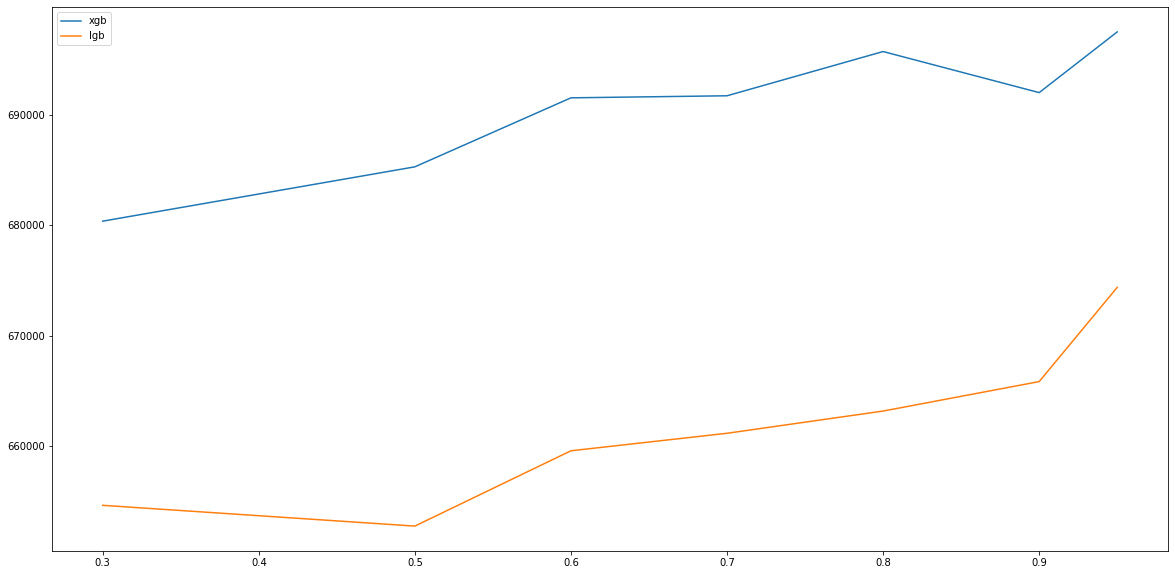

In [60]:
xgb_scores = [v[0] for v in subspace_res.values()]
lgb_scores = [v[1] for v in subspace_res.values()]
rf_scores = [v[2] for v in subspace_res.values()]

plt.subplots(figsize=FIGSIZE)
plt.plot(subspace, xgb_scores, label='xgb')
plt.plot(subspace, lgb_scores, label='lgb')
# plt.plot(subspace, rf_scores, label='rf')
plt.legend();

In [67]:
alpha=0.5

zoo_models = [ (1,alpha, XGBRegressor(n_estimators=100, colsample_bytree=.3,
                             random_state=SEED,
                             n_jobs=-1)),
              
              (1,alpha, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.3,
                                       n_jobs=-1,
                                       random_state=SEED+1)),
              
              (1,.7 * alpha, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.4,
                                       n_jobs=-1,
                                       random_state=SEED+2)),
              
              (1, .7 * alpha, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.5,
                                       n_jobs=-1,
                                       random_state=SEED+3)),
              (0, alpha, NN(input_shape=(X_array.shape[1],), epochs=500, batch_size=256))
]

In [70]:
predictions_test = np.zeros((X_test_array.shape[0], 1))
predictions_val = np.zeros((X_array.shape[0], 1))

t = 10

for i in tqdm_notebook(range(t), total=t):
    y_pred, _, y_pred_val = prediction_cluster_folds_ensemble(X_array, y, 
                                                           X_test_array,  
                                                           zoo_models,
                                                           n_clusters=4, 
                                                           n_splits=7,
                                                           seed=SEED+i)
    predictions_test += y_pred
    predictions_val += y_pred_val
    
predictions_test /= t
predictions_val /= t

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [71]:
mean_squared_error(y, predictions_val)

620733.0398620749

In [72]:
submission = pd.DataFrame(test_initial['Id'], columns=['Id'])
submission[target] = predictions_test
submission.to_csv('../data/submissions/xgb_lgb_rnd_subs_nn_10seeds_ensemble.csv', index=False)

### Stacking

In [73]:
alpha=0.5

zoo_models = [ (1,alpha, XGBRegressor(n_estimators=100, colsample_bytree=.3,
                             random_state=SEED,
                             n_jobs=-1)),
              
              (1,alpha, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.3,
                                       n_jobs=-1,
                                       random_state=SEED+1)),
              
              (1,.7 * alpha, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.4,
                                       n_jobs=-1,
                                       random_state=SEED+2)),
              
              (1, .7 * alpha, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.5,
                                       n_jobs=-1,
                                       random_state=SEED+3)),
              (0, alpha, NN(input_shape=(X_array.shape[1],), epochs=500, batch_size=256))
]

In [86]:
def meta_transformer(train_X, train_y, test_X, 
                       models, n_clusters=4,n_splits=5, seed=SEED):
    """
        train_X -- ndarray
        train_y -- ndarray with (n, 1) shape
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
    predicted_target = kmeans.fit(train_y).predict(train_y)
    
    
    num_models = len(models)
    meta_matrix_train = np.zeros((train_X.shape[0], num_models))
    meta_matrix_test = np.zeros((test_X.shape[0], num_models))

    scores = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for (tr_ind, val_ind) in tqdm_notebook(skf.split(train_X, predicted_target), 
                                           total=skf.n_splits):
        X_train_fold = train_X[tr_ind]
        y_train_fold = np.squeeze(train_y[tr_ind])

        X_valid_fold = train_X[val_ind]
        y_valid_fold = np.squeeze(train_y[val_ind])
        
        for i,(type_model, model) in enumerate(models):
            if type_model == 1:
                model_fold = clone(model)
                y_pred_valid = model_fold.fit(X_train_fold, 
                                              y_train_fold).predict(X_valid_fold)
                meta_matrix_train[val_ind, i] = y_pred_valid
                
                
                y_pred_test = model_fold.predict(test_X)
                meta_matrix_test[:, i] = y_pred_test
            else:
                y_pred_valid = model.fit(X_train_fold, y_train_fold, 
                                   X_valid_fold, y_valid_fold).predict(X_valid_fold)
                meta_matrix_train[val_ind, i] = np.squeeze(y_pred_valid)

                y_pred_test = model.predict(test_X)
                meta_matrix_test[:, i] = np.squeeze(y_pred_test)
                
    return meta_matrix_train, meta_matrix_test

In [91]:
def meta_transform_mean(train_X, train_y, test_X, models,
                        num_iterations=10,
                        n_clusters=4,n_splits=7, seed=SEED):
    
    train_meta = np.zeros((train_X.shape[0], len(models)))
    test_meta = np.zeros((test_X.shape[0], len(models)))
    
    for t in range(num_iterations):
        train_meta_curr, test_meta_curr = meta_transformer(X_array, y, X_test_array, 
                                                         models, n_clusters=n_clusters, n_splits=n_splits,
                                                          seed=seed+t)
        train_meta += train_meta_curr
        test_meta += test_meta_curr
        
    train_meta /= num_iterations
    test_meta /= num_iterations
    
    return train_meta, test_meta

In [96]:
models_check = [
    (1,XGBRegressor(n_estimators=100, colsample_bytree=.3,
                             random_state=SEED,
                             n_jobs=-1)),
              
    (1, LGBMRegressor(n_estimators=100,
                      colsample_bytree=.3,
                       n_jobs=-1,
                       random_state=SEED+1))
]

In [95]:
_, scores, _ = prediction_cluster_folds_ensemble(X_array, y, 
                                               X_test_array,  
                                               models_check,
                                               n_clusters=4, 
                                               n_splits=7,
                                               seed=SEED)
np.mean(scores)

A Jupyter Widget

664838.0907035497

In [97]:
train_meta, test_meta = meta_transform_mean(X_array, y,
                                           X_test_array, models_check,
                                           num_iterations=2)

A Jupyter Widget

A Jupyter Widget

In [100]:
# scaler = StandardScaler()
ridge = Ridge(alpha=2., random_state=SEED)

In [101]:
_, scores, _ = prediction_cluster_folds(train_meta, y, 
                                       test_meta,  
                                       ridge,
                                       n_clusters=4, 
                                       n_splits=7)
np.mean(scores)

643329.9814622458

In [124]:
alpha=0.5

zoo_models = [ (1, XGBRegressor(n_estimators=100, colsample_bytree=.3,
                             random_state=SEED,
                             n_jobs=-1)),
              
              (1, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.3,
                                       n_jobs=-1,
                                       random_state=SEED+1)),
              
              (1, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.4,
                                       n_jobs=-1,
                                       random_state=SEED+2)),
              
              (1, LGBMRegressor(n_estimators=100,
                                      colsample_bytree=.5,
                                       n_jobs=-1,
                                       random_state=SEED+3)),
              
              (0, NN(input_shape=(X_array.shape[1],), epochs=500, 
                     batch_size=256, dropout=.2)),
              
              
#               (0, NN(input_shape=(X_array.shape[1],), epochs=500, 
#                      batch_size=256, dropout=.5))
]

In [125]:
%%time
train_meta, test_meta = meta_transform_mean(X_array, y,
                                           X_test_array, zoo_models,
                                           num_iterations=10)

A Jupyter Widget

KeyboardInterrupt: 

In [110]:
# scaler = StandardScaler()
ridge = Ridge(alpha=10., random_state=SEED)

In [111]:
y_pred, scores, _ = prediction_cluster_folds(train_meta, y, 
                                       test_meta,  
                                       ridge,
                                       n_clusters=4, 
                                       n_splits=7)
np.mean(scores)

618168.5825555118

In [ ]:
ridge = Ridge(alpha=10., random_state=SEED)
y_pred = ridge.fit(train_meta, y).predict(test_meta)

In [112]:
submission = pd.DataFrame(test_initial['Id'], columns=['Id'])
submission[target] = y_pred
submission.to_csv('../data/submissions/xgb_lgb_rnd_subs_nn_stacking.csv', index=False)

In [118]:
ridge = Ridge(alpha=10., random_state=SEED)
y_pred = ridge.fit(train_meta, y).predict(test_meta)

In [119]:
submission = pd.DataFrame(test_initial['Id'], columns=['Id'])
submission[target] = y_pred
submission.to_csv('../data/submissions/xgb_lgb_rnd_subs_nn_stacking_fitall.csv', index=False)

In [114]:
train_meta_df = pd.DataFrame(train_meta, columns = ['xgb_30', 'lgb_30', 'lgb_40', 'lgb_50', 'nn_v1'])

In [115]:
test_meta_df = pd.DataFrame(test_meta, columns = ['xgb_30', 'lgb_30', 'lgb_40', 'lgb_50', 'nn_v1'])

In [117]:
train_meta_df.to_csv('../data/train_meta_v1.csv', index=False)
test_meta_df.to_csv('../data/test_meta_v1.csv', index=False)